# Word Attribution Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jtooates/blind_lm/blob/main/word_attribution_analysis.ipynb)

This notebook analyzes which parts of the RGB latent are responsible for generating each word.

**Method**: Gradient-based attribution - compute ∂(logit)/∂(latent) to see which pixels influence each word's prediction.

## 1. Environment Setup

In [1]:
# Detect environment (Colab vs Local)
try:
    from google.colab import drive
    IN_COLAB = True
    print("✓ Running in Google Colab")
except:
    IN_COLAB = False
    print("✓ Running locally")

✓ Running locally


In [8]:
# Install dependencies (if in Colab)
if IN_COLAB:
    print("Installing dependencies...")
    !pip install -q transformers torch matplotlib numpy
    print("✓ Dependencies installed")
else:
    print("✓ Skipping install (assuming dependencies already available locally)")

# Suppress tokenizer warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch

✓ Skipping install (assuming dependencies already available locally)


In [4]:
# Suppress tokenizer warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [5]:
# Mount Google Drive (for Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    print("✓ Google Drive mounted")
    print("✓ Checkpoints location: /content/drive/MyDrive/blind_lm_outputs/")
except:
    IN_COLAB = False
    print("✓ Running locally")

✓ Running locally


In [6]:
## 2. Load Model

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import sys
import os

# Add phase1 to path (handle both Colab and local)
if IN_COLAB:
    # In Colab, we're already in /content/blind_lm after cloning
    sys.path.insert(0, '/content/blind_lm/phase1')
    os.chdir('/content/blind_lm')  # Ensure we're in repo root
else:
    # Local: assume we're running from repo root
    sys.path.insert(0, 'phase1')

from model import create_model
from decoder_nonar import create_decoder
from transformers import AutoTokenizer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Determine checkpoint location based on environment
if IN_COLAB:
    checkpoint_dir = Path('/content/drive/MyDrive/blind_lm_outputs/phase1_rgb_infonce')
else:
    checkpoint_dir = Path('outputs/phase1_rgb_infonce')

checkpoint_path = checkpoint_dir / 'checkpoint_latest.pt'
config_path = checkpoint_dir / 'config.json'

# Check if files exist
if not checkpoint_path.exists():
    print(f"❌ Checkpoint not found at {checkpoint_path}")
    print("\nPlease ensure you have a trained model.")
    if IN_COLAB:
        print("Expected location: /content/drive/MyDrive/blind_lm_outputs/phase1_rgb_infonce/")
        print("You can train a model using phase1_colab_training.ipynb")
    else:
        print("Expected location: outputs/phase1_rgb_infonce/")
    raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

if not config_path.exists():
    print(f"❌ Config not found at {config_path}")
    raise FileNotFoundError(f"Config not found: {config_path}")

print(f"✓ Found checkpoint: {checkpoint_path}")
print(f"✓ Found config: {config_path}")

# Load config
with open(config_path) as f:
    config = json.load(f)

print(f"\nModel configuration:")
print(f"  Channels: {config['model']['num_channels']} (RGB)")
print(f"  Grid size: {config['model']['grid_size']}x{config['model']['grid_size']}")
print(f"  Hidden size: {config['model']['hidden_size']}")

# Create models
encoder = create_model(config['model']).to(device)
decoder = create_decoder(config['decoder']).to(device)

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
encoder.eval()
decoder.eval()

print(f"\n✓ Loaded checkpoint from step {checkpoint['step']}")

# Create tokenizer
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

print("✓ Models loaded and ready!")

Using device: cpu
✓ Found checkpoint: outputs/phase1_rgb_infonce/checkpoint_latest.pt
✓ Found config: outputs/phase1_rgb_infonce/config.json

Model configuration:
  Channels: 3 (RGB)
  Grid size: 32x32
  Hidden size: 384

✓ Loaded checkpoint from step 7400
✓ Models loaded and ready!


In [11]:
## 3. Attribution Functions

In [12]:
def compute_word_attribution(latent, decoder, word_idx, predicted_token_id, aggregation='mean'):
    """
    Compute gradient-based attribution for a specific word.
    
    Args:
        latent: [1, H, W, C] latent tensor (requires grad)
        decoder: decoder model
        word_idx: position of word in sequence
        predicted_token_id: token ID that was predicted
        aggregation: How to aggregate across RGB channels. Options:
                    'mean' - average across channels (default)
                    'max' - max across channels (shows strongest signal per position)
    
    Returns:
        heatmap: [H, W] numpy array of attribution scores
    
    Note: The heatmap aggregates across RGB channels, so it shows importance
    by spatial position (pixel location), not individual color channels.
    """
    # Forward pass
    logits = decoder(latent)  # [1, seq_len, vocab_size]
    
    # Get logit for predicted token at this position
    target_logit = logits[0, word_idx, predicted_token_id]
    
    # Backward pass
    target_logit.backward(retain_graph=True)
    
    # Get gradient magnitude
    grad = latent.grad.abs()  # [1, H, W, C]
    
    # Aggregate across RGB channels to get [H, W] heatmap
    if aggregation == 'max':
        heatmap = grad[0].max(dim=-1)[0]  # [H, W] - max returns (values, indices)
    else:  # default to mean
        heatmap = grad[0].mean(dim=-1)  # [H, W]
    
    return heatmap.detach().cpu().numpy()


def apply_topk_mask(heatmap, top_k=None):
    """
    Keep only the top-k most important pixels, zero out the rest.
    
    Args:
        heatmap: [H, W] numpy array
        top_k: If specified, keep only top k pixels. If None, keep all.
    
    Returns:
        masked_heatmap: [H, W] numpy array with only top-k values
    """
    if top_k is None:
        return heatmap
    
    # Flatten, get top-k indices
    flat_heatmap = heatmap.flatten()
    if top_k >= len(flat_heatmap):
        return heatmap  # Keep all if k >= total pixels
    
    # Get threshold value (k-th largest value)
    threshold = np.partition(flat_heatmap, -top_k)[-top_k]
    
    # Create mask keeping only values >= threshold
    masked = np.where(heatmap >= threshold, heatmap, 0)
    
    return masked


def latent_to_rgb(latent_tensor):
    """
    Convert latent [H, W, C] to displayable RGB [H, W, 3].
    """
    rgb = latent_tensor.cpu().numpy()
    # Normalize from [-1.5, 1.5] to [0, 1]
    rgb = (rgb + 1.5) / 3.0
    rgb = np.clip(rgb, 0, 1)
    return rgb


def visualize_word_attributions(encoder, decoder, tokenizer, sentence, device, 
                                top_k=None, aggregation='mean'):
    """
    Generate visualization showing which latent pixels are important for each word.
    
    Args:
        encoder: encoder model
        decoder: decoder model
        tokenizer: GPT-2 tokenizer
        sentence: input sentence
        device: 'cuda' or 'cpu'
        top_k: If specified, show only the top-k most important pixels per word.
               If None, show full heatmap. Max is 1024 (32x32). Recommended: 50-100.
        aggregation: How to aggregate RGB channel gradients. Options:
                    'mean' - average across channels (smoother, default)
                    'max' - max across channels (shows strongest signal)
    
    Display:
    - Row 0: Original RGB latent (shown once)
    - Row 1: Heatmap for each word (optionally filtered to top-k)
    - Row 2: RGB + heatmap overlay for each word
    """
    # Tokenize input
    inputs = tokenizer(sentence, return_tensors='pt', padding='max_length', 
                      truncation=True, max_length=64)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    # Encode (no grad needed here)
    with torch.no_grad():
        latent_base = encoder(input_ids, attention_mask)  # [1, 32, 32, 3]
        
        # Decode to get predictions
        logits = decoder(latent_base)
        predicted_ids = logits.argmax(dim=-1)
    
    # Get predicted tokens (skip padding)
    num_tokens = attention_mask[0].sum().item()
    predicted_tokens = tokenizer.convert_ids_to_tokens(predicted_ids[0][:num_tokens])
    predicted_token_ids = predicted_ids[0][:num_tokens].cpu().tolist()
    
    # Convert to displayable RGB
    rgb = latent_to_rgb(latent_base[0])
    
    # Compute heatmaps for each word
    print(f"Computing attributions for {len(predicted_tokens)} tokens...")
    print(f"Aggregation method: {aggregation}")
    if top_k is not None:
        print(f"Filtering to top-{top_k} most important pixels per word...")
    heatmaps = []
    
    for i, (token, token_id) in enumerate(zip(predicted_tokens, predicted_token_ids)):
        # Create latent that requires grad for this computation
        latent = latent_base.clone().detach().requires_grad_(True)
        
        # Compute attribution
        heatmap = compute_word_attribution(latent, decoder, i, token_id, aggregation=aggregation)
        
        # Apply top-k filtering if specified
        if top_k is not None:
            heatmap = apply_topk_mask(heatmap, top_k)
        
        heatmaps.append(heatmap)
        
        # Clear gradients
        if latent.grad is not None:
            latent.grad.zero_()
    
    print("✓ Attributions computed")
    
    # Create visualization
    n_tokens = len(predicted_tokens)
    fig = plt.figure(figsize=(n_tokens * 2, 8))
    
    # Row 0: Original RGB latent (spanning all columns)
    ax_rgb = plt.subplot(3, 1, 1)
    ax_rgb.imshow(rgb)
    title = f'RGB Latent for: "{sentence}"'
    if top_k is not None:
        title += f' (top-{top_k} pixels, {aggregation} aggregation)'
    else:
        title += f' ({aggregation} aggregation)'
    ax_rgb.set_title(title, fontsize=12, fontweight='bold')
    ax_rgb.axis('off')
    
    # Rows 1-2: Heatmaps and overlays for each word
    for i, (token, heatmap) in enumerate(zip(predicted_tokens, heatmaps)):
        # Row 1: Heatmap
        ax_heat = plt.subplot(3, n_tokens, n_tokens + i + 1)
        im = ax_heat.imshow(heatmap, cmap='hot', interpolation='nearest')
        ax_heat.set_title(f'{token}', fontsize=10)
        ax_heat.axis('off')
        
        # Row 2: Overlay
        ax_overlay = plt.subplot(3, n_tokens, 2 * n_tokens + i + 1)
        ax_overlay.imshow(rgb)
        ax_overlay.imshow(heatmap, cmap='hot', alpha=0.5, interpolation='nearest')
        ax_overlay.axis('off')
    
    plt.tight_layout()
    
    # Print reconstruction
    reconstruction = tokenizer.decode(predicted_ids[0][:num_tokens], skip_special_tokens=True)
    print(f"\nOriginal:       {sentence}")
    print(f"Reconstruction: {reconstruction}")
    if sentence.strip() == reconstruction.strip():
        print("✓ EXACT MATCH")
    
    return fig, predicted_tokens, heatmaps

print("✓ Attribution functions defined")

✓ Attribution functions defined


In [ ]:
## 4. Interactive Analysis

Enter a sentence to analyze which parts of the latent are responsible for each word.

## Attribution Functions

## 5. Analysis Tips

**What to look for:**

1. **Color words** (red, blue, yellow): Do they activate specific colored regions?
2. **Spatial words** (under, right, left): Do they activate specific spatial patterns?
3. **Object words** (cube, block, box): Do they have consistent activation patterns?
4. **Function words** (the, is): Typically should have low/diffuse activation

**Heatmap interpretation:**
- **Bright (yellow/white)**: High importance - this pixel strongly influenced the word
- **Dark (red/black)**: Low importance - this pixel didn't affect the word much

**About the heatmaps:**
- Heatmaps show importance by **spatial position** (pixel location in the 32x32 grid)
- **Aggregation options:**
  - `mean`: Average gradients across RGB channels (smoother, default)
  - `max`: Take maximum gradient across RGB channels (highlights strongest signal per position)
- Use **top-k filtering** (e.g., top 50 pixels) to see only the most important regions clearly
- Total spatial positions: 32×32 = **1,024 pixels**

**Questions to explore:**
- Do different occurrences of "the" activate different regions?
- Do color words consistently activate the same colored blobs?
- Do spatial relations show positional patterns in the latent?
- With top-k=50 and max aggregation, which pixels are most critical for each word type?
- Does max aggregation reveal different patterns than mean?

## 6. Try More Sentences

Run the cell below multiple times with different sentences to explore patterns.

Enter a sentence to analyze:  the blue block is next to the blue block
Aggregation method? (mean/max, default=mean):  


Using mean aggregation (average across RGB channels)


Show only top-k most important pixels? (enter number like 50, or press Enter for all):  200


Will show top-200 pixels per word (max is 1024)

Computing attributions for 9 tokens...
Aggregation method: mean
Filtering to top-200 most important pixels per word...
✓ Attributions computed

Original:       the blue block is next to the blue block
Reconstruction: the blue block is next to the blue block
✓ EXACT MATCH


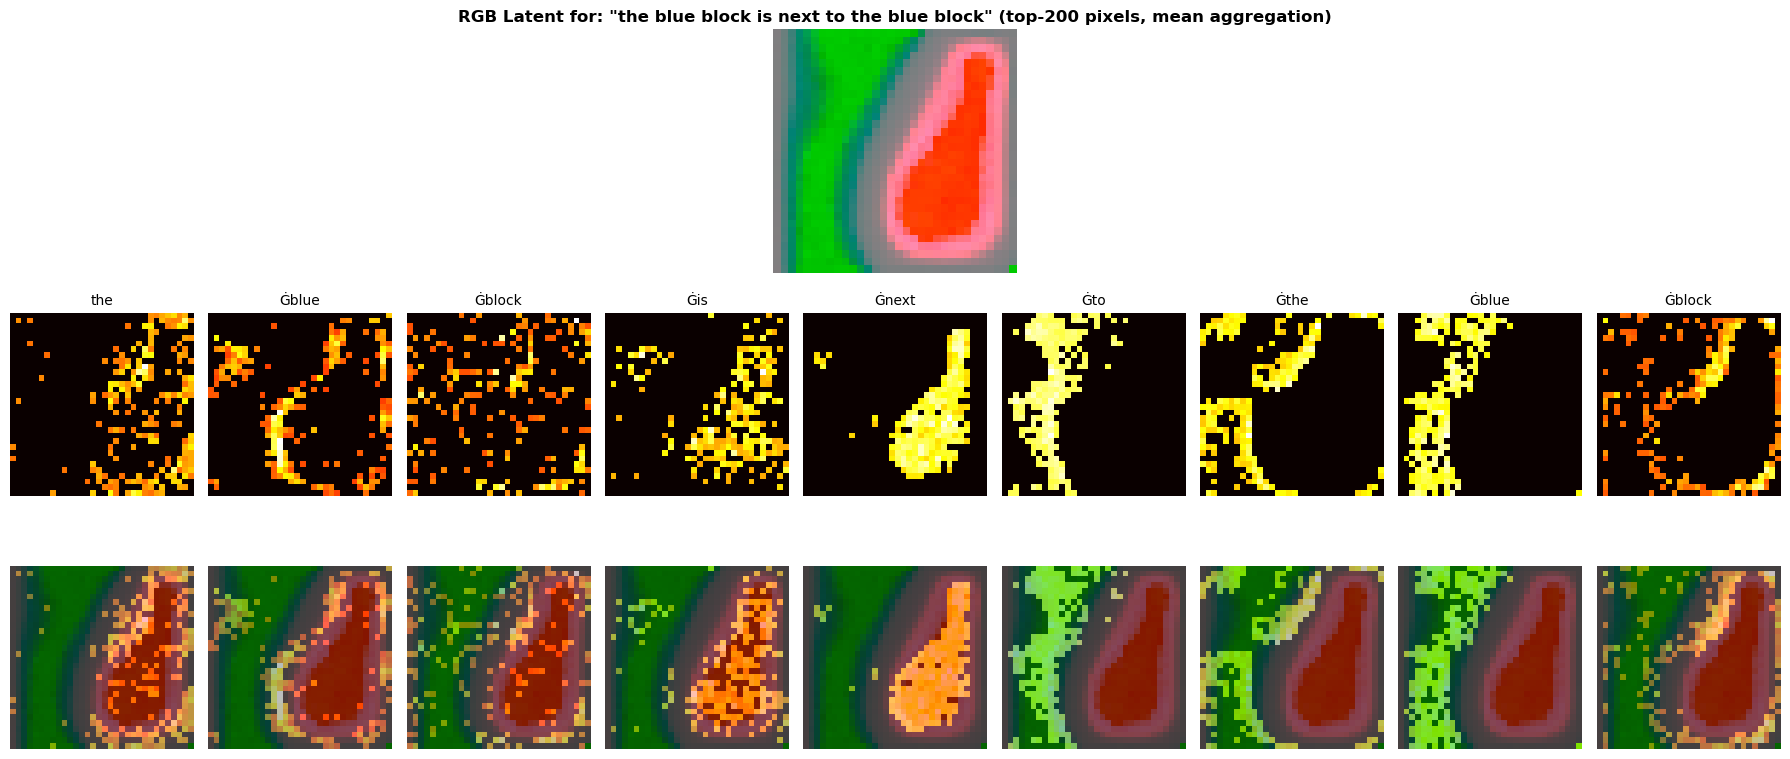

In [16]:
# Prompt for sentence and options
sentence = input("Enter a sentence to analyze: ")

if not sentence.strip():
    sentence = "the red cube is under the yellow block"  # Default example
    print(f"Using default: {sentence}")

# Ask for aggregation method
agg_input = input("Aggregation method? (mean/max, default=mean): ").strip().lower()
if agg_input in ['max', 'maximum']:
    aggregation = 'max'
    print("Using max aggregation (strongest signal per position)")
else:
    aggregation = 'mean'
    print("Using mean aggregation (average across RGB channels)")

# Ask for top-k filtering
top_k_input = input("Show only top-k most important pixels? (enter number like 50, or press Enter for all): ")
if top_k_input.strip():
    try:
        top_k = int(top_k_input)
        print(f"Will show top-{top_k} pixels per word (max is 1024)")
    except:
        top_k = None
        print("Invalid input, showing all pixels")
else:
    top_k = None
    print("Showing all pixels")

# Generate visualization
print("\n" + "="*70)
fig, tokens, heatmaps = visualize_word_attributions(encoder, decoder, tokenizer, sentence, device, 
                                                     top_k=top_k, aggregation=aggregation)
print("="*70)

plt.show()

## Analysis Tips

**What to look for:**

1. **Color words** (red, blue, yellow): Do they activate specific colored regions?
2. **Spatial words** (under, right, left): Do they activate specific spatial patterns?
3. **Object words** (cube, block, box): Do they have consistent activation patterns?
4. **Function words** (the, is): Typically should have low/diffuse activation

**Heatmap interpretation:**
- **Bright (yellow/white)**: High importance - this pixel strongly influenced the word
- **Dark (red/black)**: Low importance - this pixel didn't affect the word much

**Questions to explore:**
- Do different occurrences of "the" activate different regions?
- Do color words consistently activate the same colored blobs?
- Do spatial relations show positional patterns in the latent?

## Try More Sentences

Run the cell below multiple times with different sentences to explore patterns.

In [ ]:
# Example sentences to try:
examples = [
    "the red cube is under the yellow block",
    "the blue box is right of the green sphere",
    "the yellow block is on the red cube",
    "the green cube is left of the blue box",
]

print("Example sentences you can try:")
for i, ex in enumerate(examples, 1):
    print(f"{i}. {ex}")

print("\n" + "="*70)
sentence = input("Enter a sentence (or leave blank for random example): ")

if not sentence.strip():
    import random
    sentence = random.choice(examples)
    print(f"Using random example: {sentence}")

# Ask for aggregation method
agg_input = input("Aggregation method? (mean/max, default=mean): ").strip().lower()
if agg_input in ['max', 'maximum']:
    aggregation = 'max'
    print("Using max aggregation (strongest signal per position)")
else:
    aggregation = 'mean'
    print("Using mean aggregation (average across RGB channels)")

# Ask for top-k filtering
top_k_input = input("Show only top-k most important pixels? (enter number like 50, or press Enter for all): ")
if top_k_input.strip():
    try:
        top_k = int(top_k_input)
        print(f"Will show top-{top_k} pixels per word (max is 1024)")
    except:
        top_k = None
        print("Invalid input, showing all pixels")
else:
    top_k = None
    print("Showing all pixels")

fig, tokens, heatmaps = visualize_word_attributions(encoder, decoder, tokenizer, sentence, device, 
                                                     top_k=top_k, aggregation=aggregation)
print("="*70)
plt.show()